## IMPORTING NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from scipy import interpolate
from scipy import stats
from skimage.draw import disk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse
from tqdm import tqdm

2024-08-17 19:37:27.236239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 19:37:27.236382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 19:37:27.409994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## READING PICKLE FILE

In [2]:
wafer_df = pd.read_pickle('/kaggle/input/wafermap-ds/LSWMD.pkl' )

In [3]:
wafer_df_1 = wafer_df

## EXPLORATORY DATA ANALYSIS

In [4]:
wafer_df_1.columns

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')

In [5]:
wafer_df_1.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


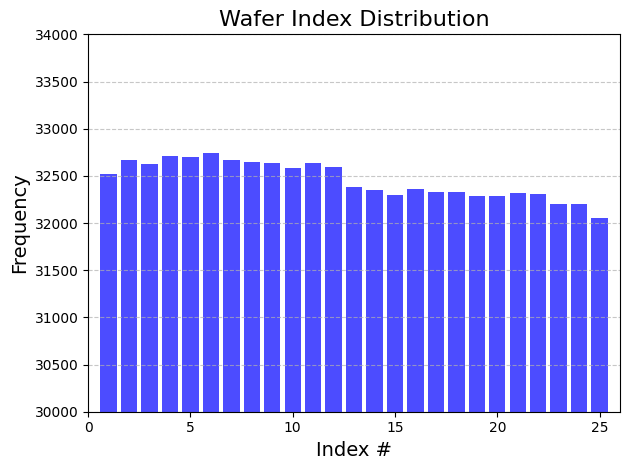

In [6]:
wafer_unqu_index=np.unique(wafer_df_1.waferIndex, return_counts=True)
plt.bar(wafer_unqu_index[0], wafer_unqu_index[1], color='blue', align='center', alpha=0.7)
plt.title("Wafer Index Distribution", fontsize=16)
plt.xlabel("Index #", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

## CHECKING FOR DIMENSION OF WAFER

In [7]:
wafer_map_shapes = []
for x in wafer_df_1['waferMap']:
    wafer_map_shapes.append(np.array(x).shape)
unique_shapes = np.unique(wafer_map_shapes, axis=0)
if len(unique_shapes) == 1:
    print(unique_shapes[0])
else:
    for shape in unique_shapes:
        print(shape)

[ 6 21]
[10 11]
[10 12]
[ 10 150]
[11 11]
[12 12]
[12 27]
[13 76]
[14 12]
[14 13]
[15  3]
[15 15]
[18  4]
[18 19]
[18 28]
[18 44]
[18 45]
[18 48]
[18 65]
[19 26]
[20 19]
[21 17]
[21 23]
[21 24]
[22 26]
[22 35]
[22 50]
[23 33]
[23 34]
[24 13]
[24 18]
[24 42]
[24 71]
[25 26]
[25 27]
[25 28]
[25 29]
[26 25]
[26 26]
[26 28]
[26 29]
[26 30]
[26 32]
[26 44]
[26 50]
[27 15]
[27 25]
[27 27]
[27 28]
[27 30]
[27 31]
[27 33]
[27 71]
[28 26]
[28 28]
[28 29]
[28 30]
[28 35]
[28 42]
[28 45]
[28 51]
[28 71]
[28 76]
[29 24]
[29 26]
[29 27]
[29 28]
[29 29]
[29 30]
[29 31]
[29 35]
[29 45]
[29 61]
[30 29]
[30 30]
[30 31]
[30 32]
[30 34]
[30 35]
[30 38]
[30 40]
[31 24]
[31 28]
[31 29]
[31 31]
[31 32]
[31 33]
[31 35]
[32 29]
[32 30]
[32 31]
[32 32]
[32 33]
[32 35]
[32 36]
[32 71]
[33 20]
[33 24]
[33 29]
[33 30]
[33 31]
[33 32]
[33 33]
[33 35]
[33 36]
[33 37]
[33 38]
[34 29]
[34 31]
[34 32]
[34 33]
[34 34]
[34 35]
[34 36]
[34 48]
[35 20]
[35 24]
[35 29]
[35 31]
[35 32]
[35 33]
[35 34]
[35 35]
[35 36]
[35 37

In [8]:
wafer_df_2 = wafer_df_1

## RESIZING THE DIMENSION OF THE WAFER TO SAME DIMENSION FOR FURTHER PROCESSING

In [9]:
mean_shape = (32,32)
resized_images = []
for x in wafer_df_2['waferMap']:
    img = Image.fromarray(x)
    resized_img = img.resize(mean_shape)
    resized_images.append(np.array(resized_img))
wafer_df_2['waferMap'] = resized_images
print(f"Resized image shape: {wafer_df_2['waferMap'][0].shape}")

Resized image shape: (32, 32)


In [10]:
wafer_df_2.shape[0]

811457

In [11]:
wafer_df_3 = wafer_df_2

In [12]:
wafer_df_3.columns

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')

## MAPPING CATEGORICAL VALUES

In [13]:
mapping_type = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8}
mapping_traintest = {'Training': 0, 'Test': 1}
wafer_df_3['failureNum'] = wafer_df_3['failureType'].replace(mapping_type)
wafer_df_3['trainTestNum'] = wafer_df_3['trianTestLabel'].replace(mapping_traintest)

In [14]:
wafer_df_4 = wafer_df_3

In [15]:
wafer_df_4.columns

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType', 'failureNum', 'trainTestNum'],
      dtype='object')

In [16]:
wafer_df_4.shape[0]

811457

In [17]:
wafer_df_4_withlabel = wafer_df_4[(wafer_df_4['failureNum'] >= 0) & (wafer_df_4['failureNum'] <= 8)]
wafer_df_4_withlabel = wafer_df_4_withlabel.reset_index()
wafer_df_4_withpattern = wafer_df_4[(wafer_df_4['failureNum'] >= 0) & (wafer_df_4['failureNum'] <= 7)]
wafer_df_4_withpattern = wafer_df_4_withpattern.reset_index()
wafer_df_4_nonpattern = wafer_df_4[(wafer_df_4['failureNum'] == 8)]
wafer_df_4_withlabel.shape[0], wafer_df_4_withpattern.shape[0], wafer_df_4_nonpattern.shape[0]

(172950, 25519, 147431)

## GETTING THE PERCENTAGE OF LABELLED AND UNLABELLED DATA

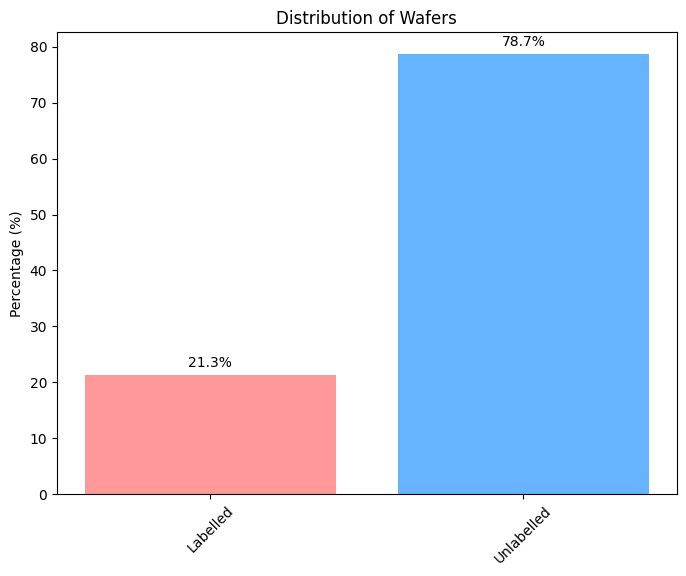

In [18]:
total_samples = len(wafer_df_4)
label_counts = wafer_df_4_withlabel.shape[0]
pattern_counts = wafer_df_4_withpattern.shape[0]
non_pattern_counts = wafer_df_4_nonpattern.shape[0]
pattern_percentage = (pattern_counts / total_samples) * 100
non_pattern_percentage = (non_pattern_counts / total_samples) * 100
labelled_percentage = ((pattern_counts + non_pattern_counts) / total_samples) * 100
unlabelled_percentage = ((total_samples - label_counts) / total_samples) * 100
categories = ['Labelled', 'Unlabelled']
percentages = [labelled_percentage, unlabelled_percentage]
colors = ['#ff9999', '#66b3ff']
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=colors)
plt.ylabel('Percentage (%)')
plt.title('Distribution of Wafers')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.show()

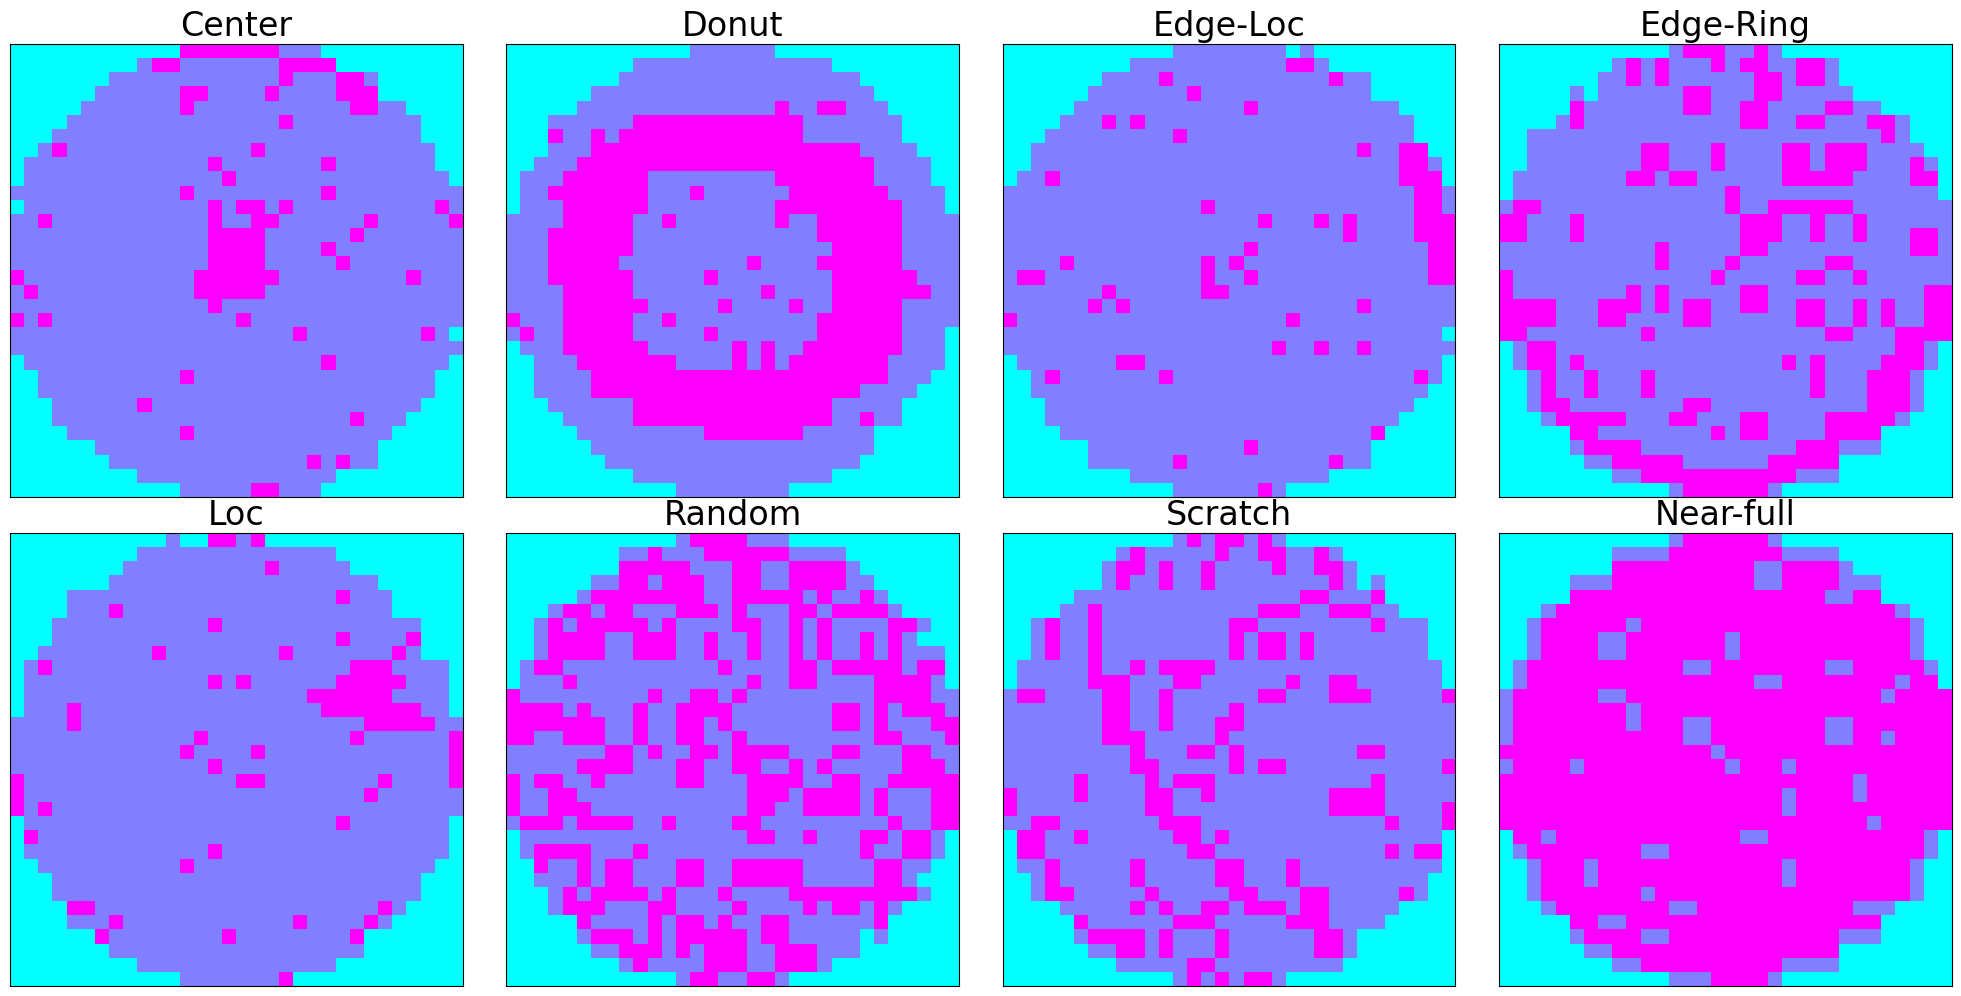

In [19]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full']
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = wafer_df_4_withpattern.waferMap[x[i]]
    ax[i].imshow(img, cmap='cool')
    ax[i].set_title(wafer_df_4_withpattern.failureType[x[i]][0][0], fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## VISUALS OF DIFFERENT PATTERNS OF DEFFECTS IN WAFER MAP

In [20]:
def change_val(img):
    img[img==1] =0
    return img
wafer_df_4_withpattern_cpy = wafer_df_4_withpattern.copy()
wafer_df_4_withpattern_cpy['new_waferMap'] =wafer_df_4_withpattern_cpy.waferMap.apply(change_val)

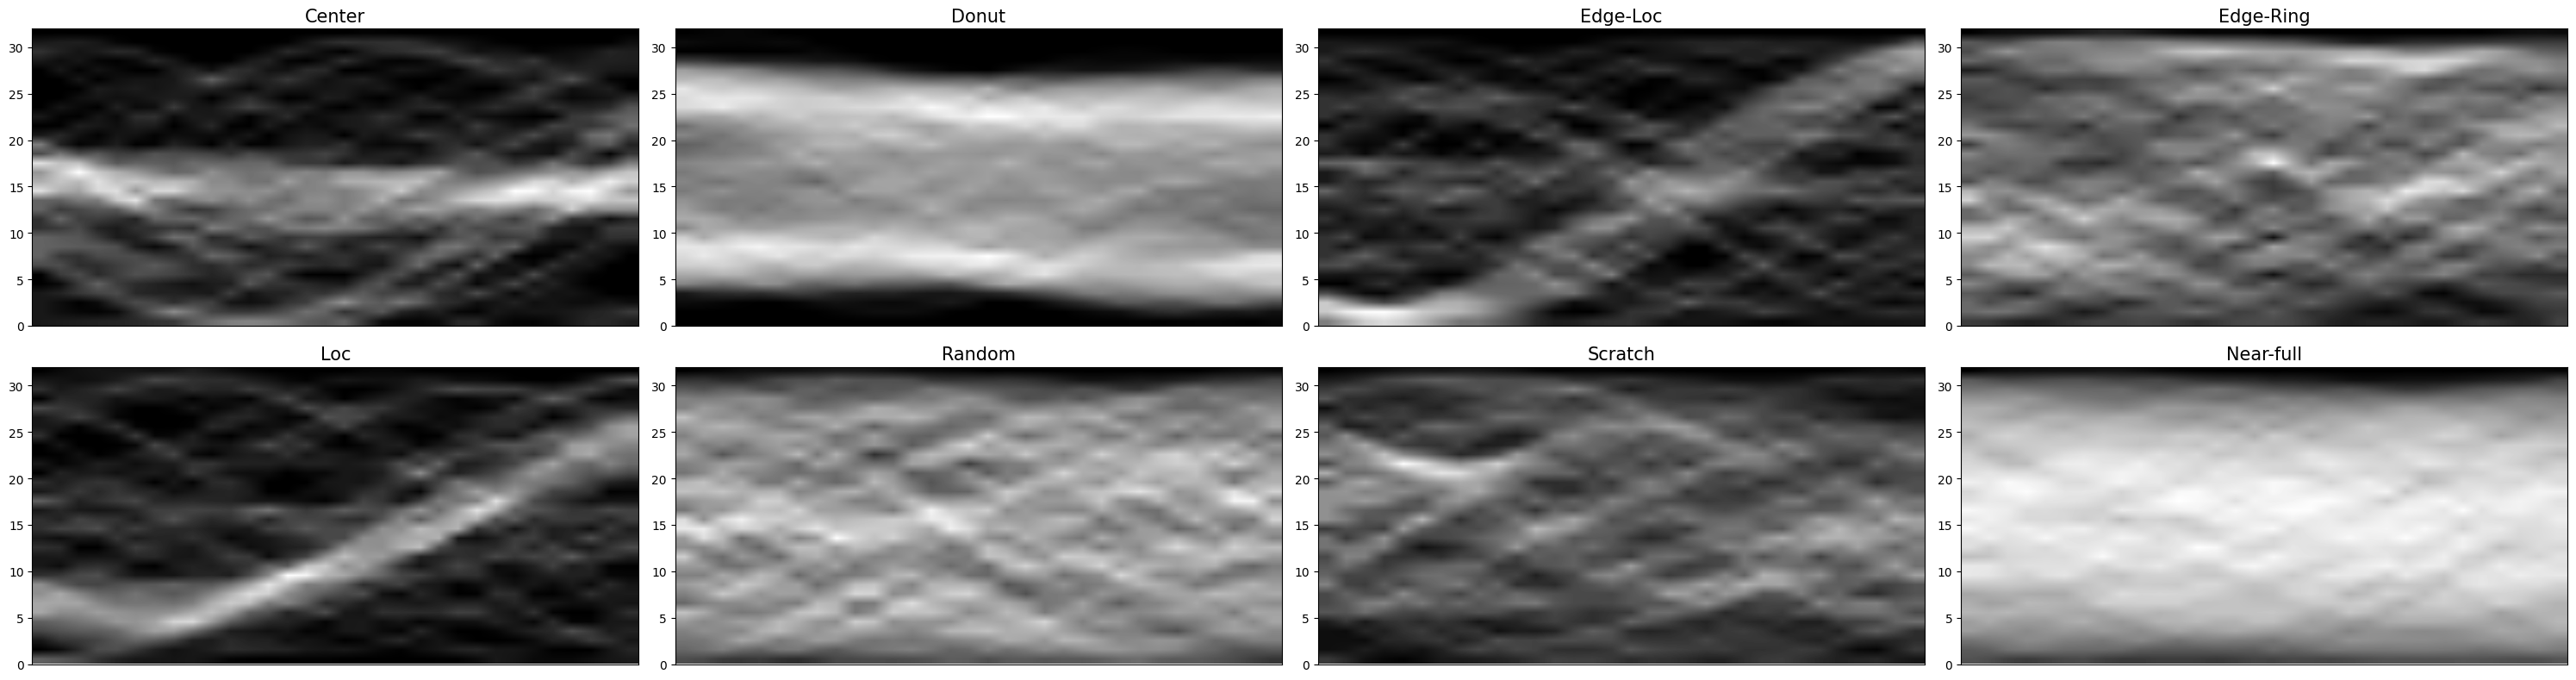

In [21]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full']
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 8))
ax = ax.ravel(order='C')
for i in range(8):
    img = wafer_df_4_withpattern_cpy.waferMap[x[i]]
    circle_mask = np.zeros_like(img)
    rr, cc = disk((img.shape[0] // 2, img.shape[1] // 2), min(img.shape) // 2, shape=img.shape)
    circle_mask[rr, cc] = 1
    img = img * circle_mask
    theta = np.linspace(0., 180., max(img.shape) , endpoint=False)
    sinogram = radon(img, theta=theta)
    extent = (0, 180, 0, sinogram.shape[0])
    ax[i].imshow(sinogram, cmap=plt.cm.gray, extent=extent, aspect='auto', interpolation='bilinear')
    ax[i].set_title(wafer_df_4_withpattern_cpy.failureType[x[i]][0][0], fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show()

In [22]:
print(wafer_df_4_withpattern['failureNum'].dtype)

object


In [23]:
wafer_df_4_withpattern['failureNum'] = pd.to_numeric(wafer_df_4_withpattern['failureNum'], errors='coerce')

In [24]:
print(wafer_df_4_withpattern['failureNum'].isna().sum())
wafer_df_4_withpattern.dropna(subset=['failureNum'], inplace=True)

0


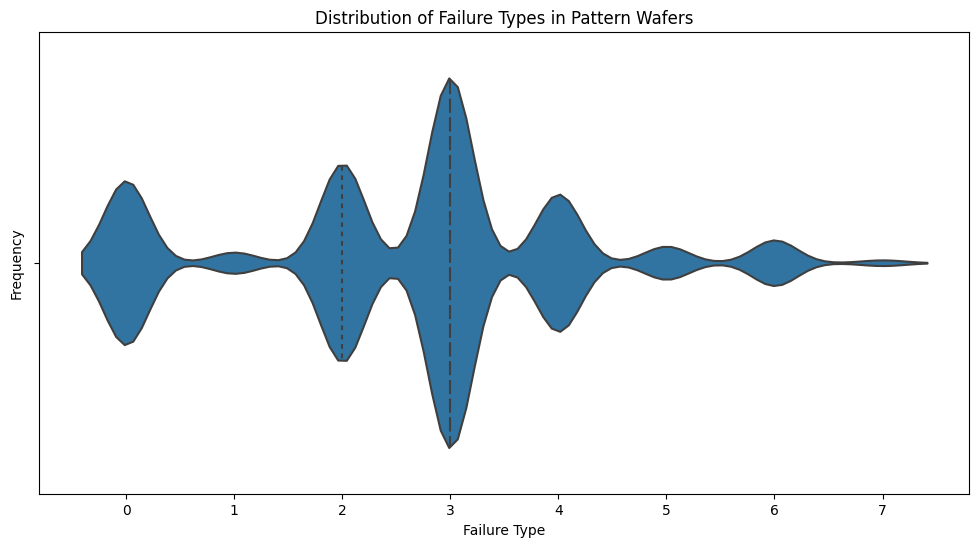

In [25]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='failureNum', data=wafer_df_4_withpattern, inner='quartile', linewidth=1.5)
plt.xlabel('Failure Type')
plt.ylabel('Frequency')
plt.title('Distribution of Failure Types in Pattern Wafers')
plt.show()

## Pie Chart Representation of different Error Patters based on its count

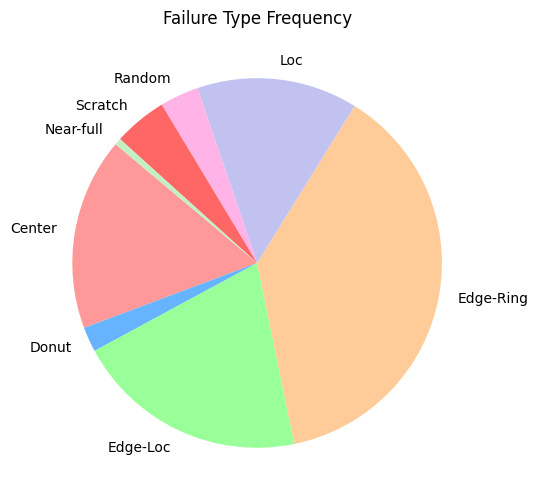

In [26]:
uni_pattern = wafer_df_4_withpattern['failureNum'].value_counts()
failure_names = {
    0: 'Center',
    1: 'Donut',
    2: 'Edge-Loc',
    3: 'Edge-Ring',
    4: 'Loc',
    5: 'Random',
    6: 'Scratch',
    7: 'Near-full',
    8: 'none'
}
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666', '#c2f0c2', '#ffb366']
labels = [failure_names[num] for num in range(9) if num in uni_pattern.index]
counts = [uni_pattern[num] for num in range(9) if num in uni_pattern.index]
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, colors=colors[:len(labels)], startangle=140)
plt.title("Failure Type Frequency")
plt.show()

In [27]:
wafer_df_4.columns

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType', 'failureNum', 'trainTestNum'],
      dtype='object')

In [28]:
unlabeled_data = wafer_df_4[wafer_df_4['failureNum'] == 8]
X_unlabeled = np.stack(unlabeled_data['waferMap'].values)
num_samples, height, width = X_unlabeled.shape
X_unlabeled = X_unlabeled.reshape(-1, height, width, 1)

## AutoEncoders for feature extraction and dimensionality reduction

In [29]:
# Define the encoder
encoder_input = Input(shape=(height, width, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Define the decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(encoder_input, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()
# Train the autoencoder on unlabelled data
autoencoder.fit(X_unlabeled, X_unlabeled, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)
autoencoder.save('wafer_model_train.h5')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 343,681 (1.31 MB)

 Trainable params: 342,721 (1.31 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 317s 42ms/step - loss: 0.1050 - val_loss: 0.0630
Epoch 2/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 307s 42ms/step - loss: 0.0965 - val_loss: 0.0622
Epoch 3/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 307s 42ms/step - loss: 0.0964 - val_loss: 0.0627
Epoch 4/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 313s 42ms/step - loss: 0.0959 - val_loss: 0.0612
Epoch 5/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 306s 42ms/step - loss: 0.0957 - val_loss: 0.0608
Epoch 6/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 315s 43ms/step - loss: 0.0959 - val_loss: 0.0609
Epoch 7/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 322s 44ms/step - loss: 0.0958 - val_loss: 0.0611
Epoch 8/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 318s 43ms/step - loss: 0.0958 - val_loss: 0.0608
Epoch 9/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 319s 43ms/step - loss: 0.0958 - val_loss: 0.0607
Epoch 10/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 319s 43ms/step - loss: 0.0956 - val_loss: 0.0617
Epoch 11/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 307s 42ms/step - loss: 0.0957 - val_loss: 0.06

In [30]:
autoencoder = load_model('wafer_model_train.h5', custom_objects={'mse': mse})
encoder_input = autoencoder.input
encoded_layer = autoencoder.layers[-11].output
encoder = Model(encoder_input, encoded_layer)
features_unlabeled = encoder.predict(X_unlabeled)
features_unlabeled = features_unlabeled.reshape((features_unlabeled.shape[0], -1))

4608/4608 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step


In [31]:
np.save('features_unlabeled.npy', features_unlabeled)

In [32]:
features_unlabeled = np.load('features_unlabeled.npy')

## Finding optimal number of clusters using Silhouette Scores

  0%|          | 0/8 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 12%|█▎        | 1/8 [37:53<4:25:13, 2273.34s/it]

Number of clusters: 2, Silhouette score: 0.1233


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|██▌       | 2/8 [1:16:16<3:49:06, 2291.01s/it]

Number of clusters: 3, Silhouette score: 0.1321


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 38%|███▊      | 3/8 [1:55:13<3:12:39, 2311.95s/it]

Number of clusters: 4, Silhouette score: 0.1482


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 50%|█████     | 4/8 [2:34:32<2:35:21, 2330.40s/it]

Number of clusters: 5, Silhouette score: 0.1683


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 62%|██████▎   | 5/8 [3:14:36<1:57:50, 2356.99s/it]

Number of clusters: 6, Silhouette score: 0.1807


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 75%|███████▌  | 6/8 [3:55:06<1:19:23, 2381.78s/it]

Number of clusters: 7, Silhouette score: 0.1993


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 88%|████████▊ | 7/8 [4:35:38<39:58, 2398.16s/it]  

Number of clusters: 8, Silhouette score: 0.2131


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 8/8 [5:17:14<00:00, 2379.29s/it]

Number of clusters: 9, Silhouette score: 0.2206


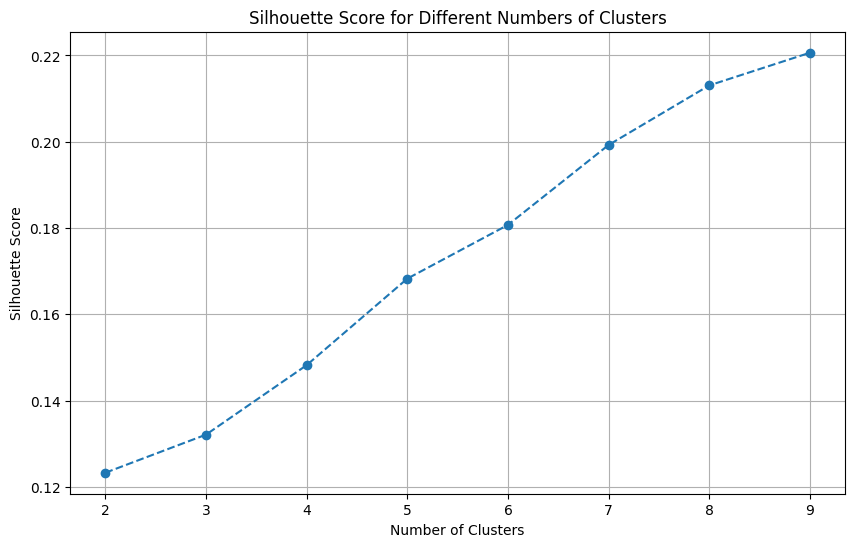

Optimal number of clusters: 9, Silhouette score: 0.2206


In [33]:
# Evaluate silhouette score for different numbers of clusters
silhouette_scores = []
cluster_range = range(2, 10)

for n_clusters in tqdm(cluster_range):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_unlabeled)
    silhouette_avg = silhouette_score(features_unlabeled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Number of clusters: {n_clusters}, Silhouette score: {silhouette_avg:.4f}')

# Plot the silhouette scores to determine the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# Use the silhouette score plot to determine the optimal number of clusters
optimal_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimal number of clusters: {optimal_n_clusters}, Silhouette score: {max(silhouette_scores):.4f}')

## Apply K-Means clustering to cluster the unlabelled data of defect wafer map using silhouette Score

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_33/2966829403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['cluster'] = clusters_unlabeled


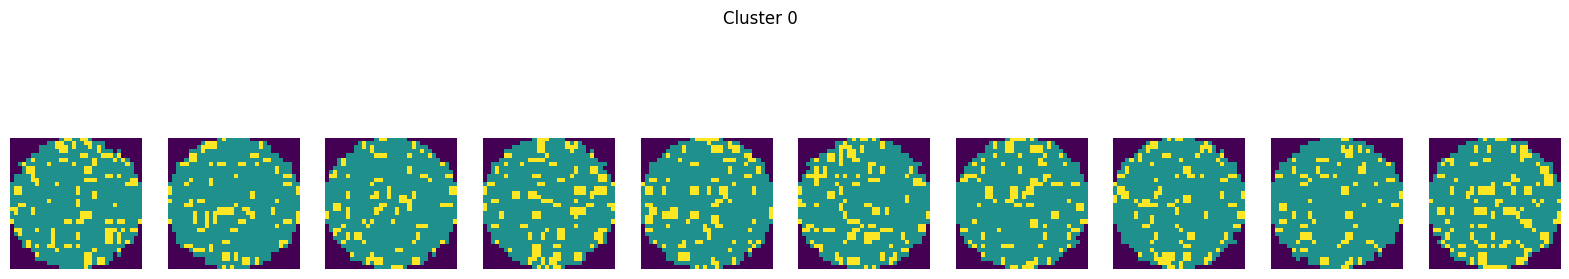

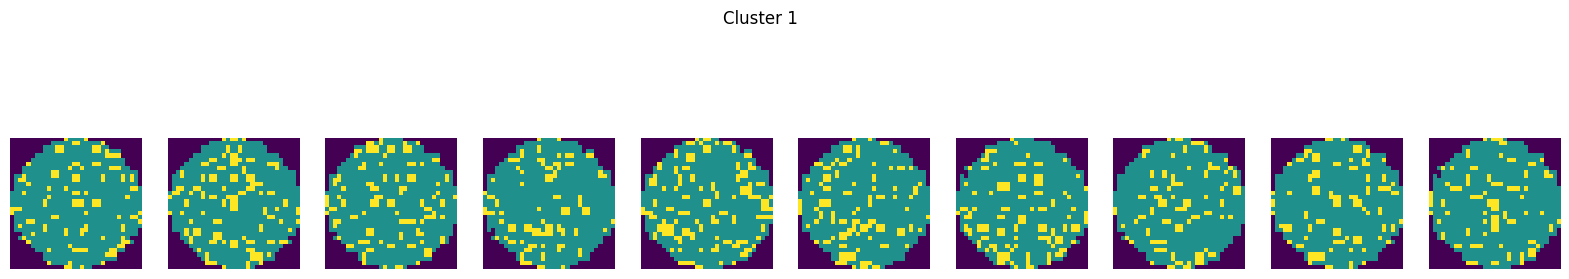

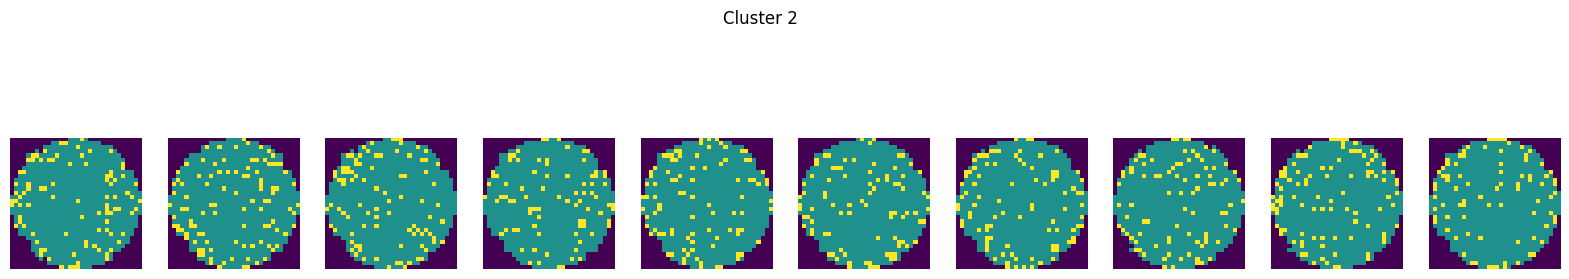

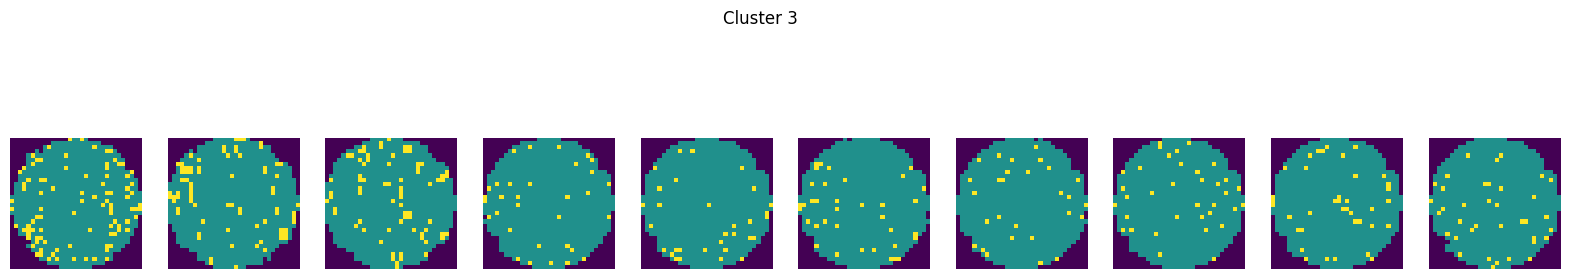

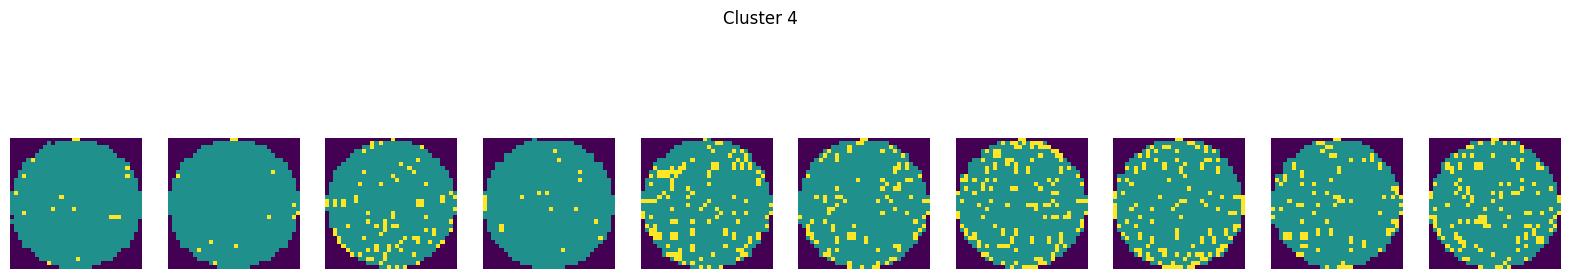

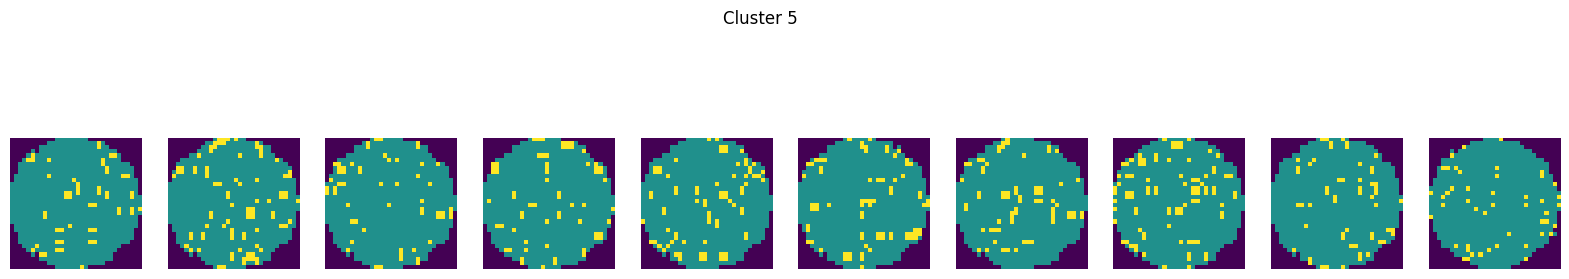

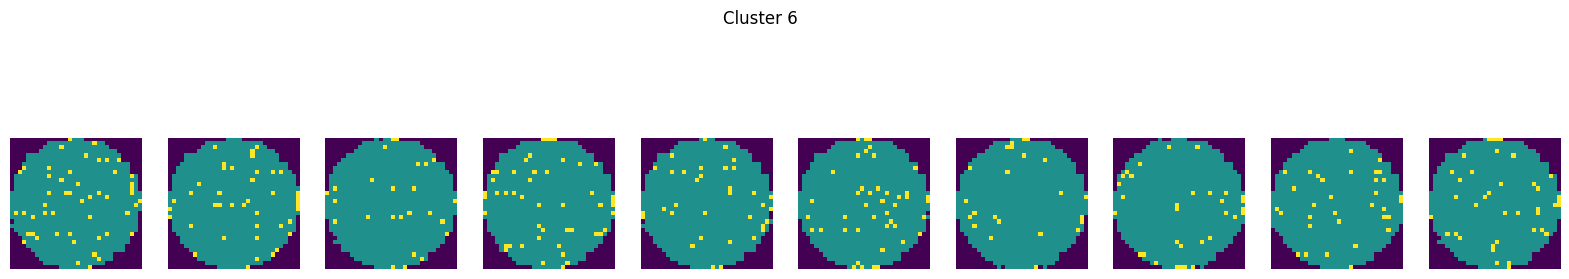

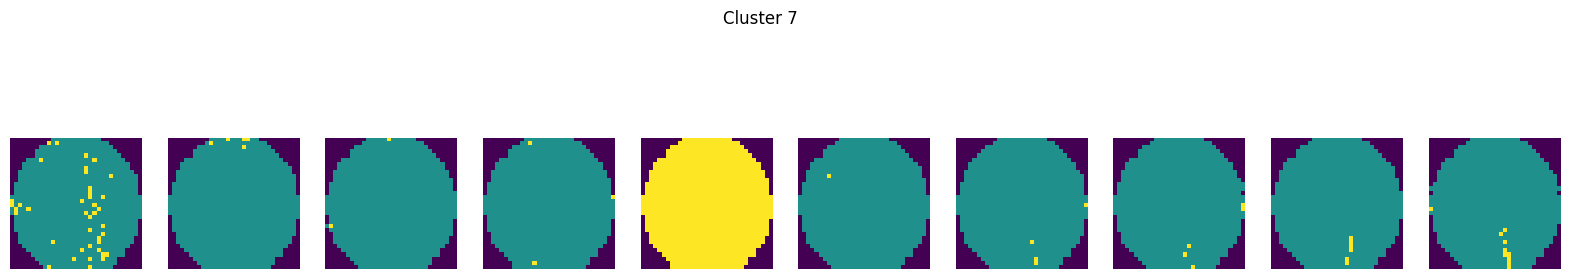

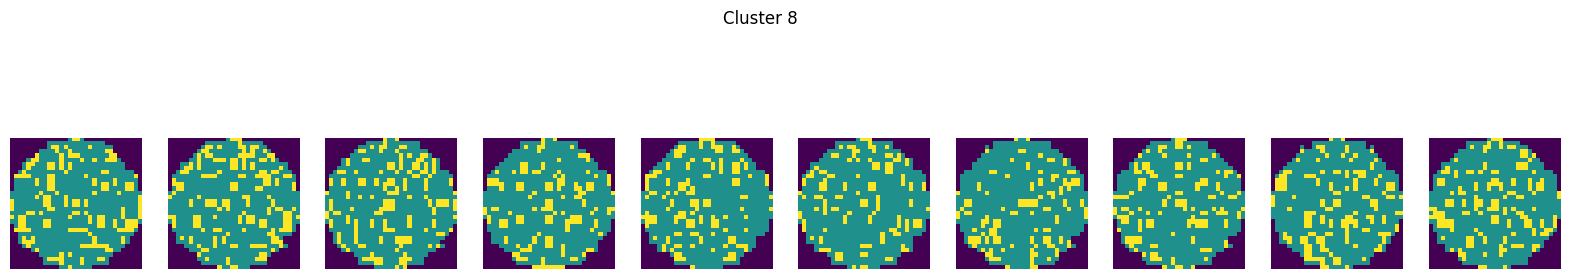

In [35]:
# Apply k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters)
clusters_unlabeled = kmeans.fit_predict(features_unlabeled)
unlabeled_data['cluster'] = clusters_unlabeled

# Visualize some clusters of the unlabeled data
for cluster_id in range(optimal_n_clusters):
    cluster_samples = unlabeled_data[unlabeled_data['cluster'] == cluster_id]['waferMap'].values
    plt.figure(figsize=(20, 4))
    for i, sample in enumerate(cluster_samples[:10]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(sample)  
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id}')
    plt.show()

Reference : https://arxiv.org/html/2404.15436v1
https://ieeexplore.ieee.org/document/9963274

DataSet Link : https://www.kaggle.com/code/iamrajanjha/wm811k-wafer-map-images/input?select=LSWMD.pkl